In [165]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import time

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from dataset.bdd100k_seg.labels import *
from PIL import Image

In [166]:
seed = 42
np.random.seed = seed

In [167]:
# Storing labels in dicionary
labelID = {}
rgbColorID = {}

for index,label in enumerate(labels):
    labelID[index] = label.name
    rgbColorID[index] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ego vehicle', 3: 'ground', 4: 'static', 5: 'parking', 6: 'rail track', 7: 'road', 8: 'sidewalk', 9: 'bridge', 10: 'building', 11: 'fence', 12: 'garage', 13: 'guard rail', 14: 'tunnel', 15: 'wall', 16: 'banner', 17: 'billboard', 18: 'lane divider', 19: 'parking sign', 20: 'pole', 21: 'polegroup', 22: 'street light', 23: 'traffic cone', 24: 'traffic device', 25: 'traffic light', 26: 'traffic sign', 27: 'traffic sign frame', 28: 'terrain', 29: 'vegetation', 30: 'sky', 31: 'person', 32: 'rider', 33: 'bicycle', 34: 'bus', 35: 'car', 36: 'caravan', 37: 'motorcycle', 38: 'trailer', 39: 'train', 40: 'truck'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (0, 0, 0), 3: (81, 0, 81), 4: (0, 0, 0), 5: (250, 170, 160), 6: (230, 150, 140), 7: (128, 64, 128), 8: (244, 35, 232), 9: (150, 100, 100), 10: (70, 70, 70), 11: (190, 153, 153), 12: (180, 100, 180), 13: (180, 165, 180), 14: (150, 120, 90), 15: (102, 102, 156), 16: (250, 170, 100), 17: (220, 220, 250), 18: (255, 165, 0), 

In [168]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
#     print(num_classes)
    shape = rgb_image.shape[:2]+(num_classes,)
#     print(type(shape))
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image

In [178]:
trainingImagesNames = []
trainingMasksNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/train/*.jpg'):
    trainingImagesNames.append(filename)

for filename in glob.glob('dataset/bdd100k_seg/color_labels/train/*.png'):
    trainingMasksNames.append(filename)

valI = trainingImagesNames[5000:7000]
valM = trainingMasksNames[5000:7000]
trainingImagesNames = trainingImagesNames[0:5000]
trainingMasksNames = trainingMasksNames[0:5000]

In [180]:
validationImagesNames = []
validationMasksNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/val/*.jpg'):
    validationImagesNames.append(filename)

for filename in glob.glob('dataset/bdd100k_seg/color_labels/val/*.png'):
    validationMasksNames.append(filename)

validationImagesNames = validationImagesNames + valI
validationMasksNames = validationMasksNames + valM

In [181]:
# Defining Hyperparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
numClasses = 41
batchSize = 1
learningRate = 0.05
stepsPerEpoch = len(trainingImagesNames)//batchSize
numOfEpoch = 100
validationSteps = len(validationImagesNames)//batchSize

In [182]:
class My_Generator(tf.keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X_train = []
        Y_train = []
        
        for image in batch_x:
            train = cv2.imread(image)
            train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            X_train.append(train)

        for image in batch_y:
            Mask = Image.open(image).convert('RGB')
            Mask = np.asarray(Mask)
            Mask = cv2.resize(Mask, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            Mask = rgb_to_onehot(Mask, rgbColorID)
            Y_train.append(Mask)
            
        return (np.array(X_train, dtype='uint8'), np.array(Y_train, dtype='uint8'))


In [133]:
# Building the segnet model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values


# Encoder 
# layer 1
c1 = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Activation('relu')(c1)
c1 = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Activation('relu')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

# layer 2
c2 = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Activation('relu')(c2)
c2 = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Activation('relu')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

# layer 3
c3 = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Activation('relu')(c3)
c3 = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same')(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Activation('relu')(c3)
c3 = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same')(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Activation('relu')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

# layer 4
c4 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Activation('relu')(c4)
c4 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Activation('relu')(c4)
c4 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Activation('relu')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

# layer 5
c5 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Activation('relu')(c5)
c5 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Activation('relu')(c5)
c5 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Activation('relu')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

# Encoder Complete

# Decoder
# layer 6
u6 = tf.keras.layers.UpSampling2D((2,2))(p5)
c6 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Activation('relu')(c6)
c6 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Activation('relu')(c6)
c6 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Activation('relu')(c6)


# layer 7
u7 = tf.keras.layers.UpSampling2D((2,2))(c6)
c7 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Activation('relu')(c7)
c7 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Activation('relu')(c7)
c7 = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Activation('relu')(c7)

# layer 8
u8 = tf.keras.layers.UpSampling2D((2,2))(c7)
c8 = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Activation('relu')(c8)
c8 = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Activation('relu')(c8)

# layer 9
u9 = tf.keras.layers.UpSampling2D((2,2))(c8)
c9 = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Activation('relu')(c9)
c9 = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Activation('relu')(c9)

# layer 10
u10 = tf.keras.layers.UpSampling2D((2,2))(c9)
c10 = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.BatchNormalization()(c10)
c10 = tf.keras.layers.Activation('relu')(c10)
c10 = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.BatchNormalization()(c10)

outputs = tf.keras.layers.Conv2D(41, (1,1), activation='softmax', padding='same')(c10)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='Segnet')
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate), loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses)])
model.summary()

Model: "Segnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda_20 (Lambda)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_324 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_315 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_335 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_325 (Bat (None, 128, 128, 64)      256  

In [183]:
# Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  monitor='mean_io_u_9',
                                                  mode='max')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='mean_io_u_9',
                                              mode='max'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [ ]:
trainingDataGenerator = My_Generator(trainingImagesNames, trainingMasksNames, batchSize)
validationDataGenerator = My_Generator(validationImagesNames, validationMasksNames, batchSize)



results = model.fit(trainingDataGenerator,
                              validation_data=validationDataGenerator,
                              steps_per_epoch=stepsPerEpoch,
                              epochs=numOfEpoch,
                              validation_steps= validationSteps,
#                               use_multiprocessing=True,
                              max_queue_size=8,
                              verbose=1,
                              callbacks=callbacks)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5000 steps, validate for 3000 steps
Epoch 1/100
4230/5000 [========================>.....] - ETA: 2:20 - loss: 1.7721 - mean_io_u_9: 0.4847- ETA: 2:34 - loss: 1.7707 - mean_io_u_9: 0 - ETA: - ETA: 2:25 - loss: 1.

In [138]:
# serialize model to JSON
model_json = model.to_json()
with open("Output/model/segnet/segnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Output/model/segnet/segnet.h5")
print("Saved model to disk")

Saved model to disk


In [161]:
# Processing the RGB masks
processing = False
count = 1
if processing:
    Y_trainRGB = []
    print('Resizing val masks')
    count = 0
    for filename in glob.glob('dataset/bdd100k_seg/images/val/*.jpg'):
        if count == 100:
            break
        img = cv2.imread(filename)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        if count == 1:
            print(img.shape)
        Y_trainRGB.append(img)
        count += 1
        print(count)
    
    Y_trainRGB = np.array(Y_trainRGB, dtype='uint8')
    np.save('NPY files/valNPYfiles/MultiClassValData', Y_trainRGB)
            
    print('Training Mask resizing Finished')
else:
    print('Masks already processed. Modify processing parameter to False to process input images again.')

Masks already processed. Modify processing parameter to False to process input images again.


In [162]:
# Processing the RGB masks
processing = False
count = 1
if processing:
    Y_trainRGB = []
    print('Resizing val masks')
    count = 0
    for filename in glob.glob('dataset/bdd100k_seg/color_labels/val/*.png'):
        if count == 100:
            break
        img = Image.open(filename).convert('RGB')
        img = np.asarray(img)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        if count == 1:
            print(img.shape)
        Y_trainRGB.append(img)
        count += 1
        print(count)
    
    Y_trainRGB = np.array(Y_trainRGB, dtype='uint8')
    np.save('NPY files/valNPYfiles/MultiClassValMasksRGB', Y_trainRGB)
            
    print('Training Mask resizing Finished')
else:
    print('Masks already processed. Modify processing parameter to False to process input images again.')

Masks already processed. Modify processing parameter to False to process input images again.


In [141]:
X_test = np.load('NPY files/valNPYfiles/MultiClassValData.npy')
print(X_test[0].shape)

Y_test = np.load('NPY files/valNPYfiles/MultiClassValMasksRGB.npy')

(128, 128, 3)


In [142]:
testingImagesNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/test/*.jpg'):
    testingImagesNames.append(filename)

In [143]:
# load json and create model
json_file = open('Output/model/segnet/segnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("segnet.h5")
print("Loaded model from disk")

Loaded model from disk


In [149]:
preds_test = loaded_model.predict(X_test[0:20], verbose=1)

20/20 [==============================] - 1s 36ms/sample


In [150]:
print(preds_test[0].shape)

(128, 128, 41)


In [151]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)


In [152]:
preds_testRGB = []
for image in preds_test:
    preds_testRGB.append(onehot_to_rgb(image,rgbColorID))
    

preds_testRGB = np.array(preds_testRGB)


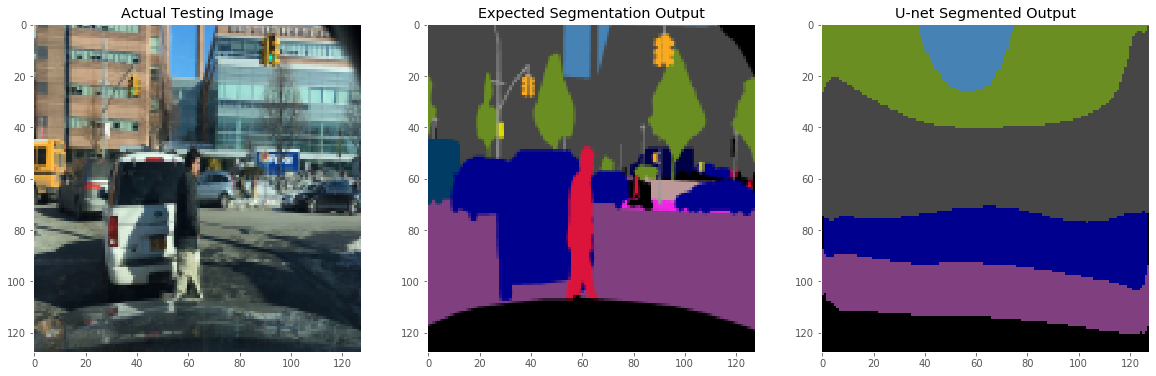

In [158]:
# Batch size = 8 
# Learning Rate = 0.001

ix = random.randint(0, len(preds_test))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(cv2.cvtColor(X_test[ix], cv2.COLOR_BGR2RGB))
ax1.title.set_text('Actual Testing Image')
ax1.grid(False)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_testRGB[ix])
ax3.grid(False)

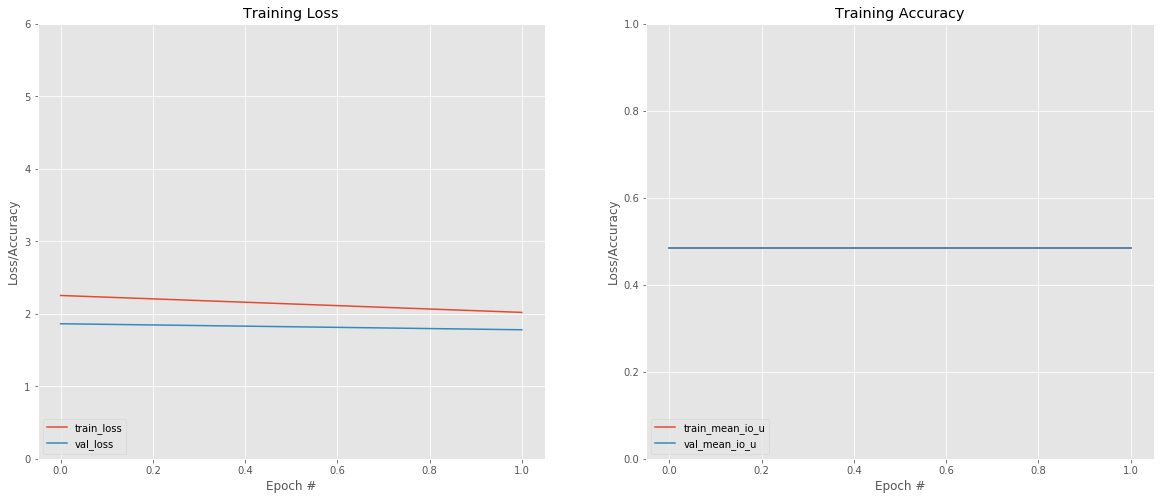

In [160]:
# Batch size = 1 
# Learning Rate = 0.001
# Img size = 128 x 128 x 3

N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 6)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.show()

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u_9"], label="train_mean_io_u")
plt.plot(np.arange(0, N), results.history["val_mean_io_u_9"], label="val_mean_io_u")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()